In [1]:
import pandas as pd
import xgboost as xgb
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Permuted Data")
df=df.sort_values(by="QED")
df

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


,Standardized_SMILES,pchembl_value,MolWt,LogP,QED
243,COc1cc(-c2cc(NC(=O)Nc3ccc(OCCCN4CCOCC4)cc3C)cc...,7.09,592.693,5.63112,0.107044
1435,COc1cc(-c2cc(NC(=O)Nc3ccc(OCCCN(C)C)cc3C)cc(OC...,7.84,550.656,5.86052,0.112004
214,COc1cc2[nH]cnc(=Nc3ccc(Br)cc3)c2cc1OCCCCCCC(O)=NO,7.13,489.370,5.24140,0.118560
1106,COc1cc2[nH]cnc(=Nc3ccc(Cl)cc3)c2cc1OCCCCCCC(O)=NO,6.67,444.919,5.13230,0.131771
792,COc1cc2[nH]cnc(=Nc3ccccc3Cl)c2cc1OCCCCCCC(O)=NO,6.44,444.919,5.13230,0.131771
...,...,...,...,...,...
1024,COc1cc2[nH]cnc(=Nc3ccccc3F)c2cc1OC,5.57,299.305,2.95160,0.808596
681,CCOc1[nH]c(=Nc2ccc(S(=N)(=O)CC)cc2)ncc1Br,7.05,385.287,3.22887,0.827970
333,Cn1cc(N=c2[nH]cc(C(F)(F)F)c(=NC3CC4CCC3C4)[nH]...,6.08,352.364,2.41680,0.855823
58,CCN(CC)C(=O)c1cccc(N2CCc3[nH]c(=N)ncc3C2)c1,5.90,325.416,1.93387,0.901718


In [2]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=20488):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [3]:
smiles = df['Standardized_SMILES'].values

In [4]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_fcv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]

    rmse=list()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        model = xgb.XGBRegressor(n_estimators=min(25, round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("sorted_fcv_results_xgboost_training batches.csv", index=False)
    test_df.to_csv("sorted_fcv_results_xgboost_testing batches.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=0.6170079899506358, pvalue=1.3998017963267765e-18)
PearsonRResult(statistic=0.6526740926970611, pvalue=2.8261380177506963e-21)
PearsonRResult(statistic=0.48856744104251193, pvalue=3.20347299688494e-11)
PearsonRResult(statistic=0.7357690371890263, pvalue=3.214270132449252e-29)
PearsonRResult(statistic=0.7119961677022333, pvalue=1.1654163292564537e-26)
PearsonRResult(statistic=0.711258633318044, pvalue=1.3859025025469395e-26)
PearsonRResult(statistic=0.7411104746832928, pvalue=7.828664844400897e-30)
PearsonRResult(statistic=0.5703279974725913, pvalue=1.5645086123151763e-15)
PearsonRResult(statistic=0.5952876781073704, pvalue=3.3852833003747795e-17)


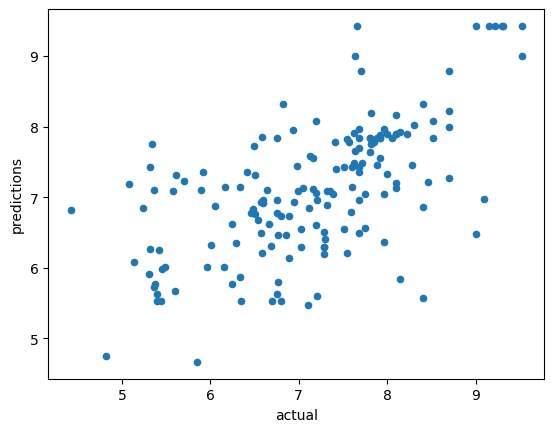

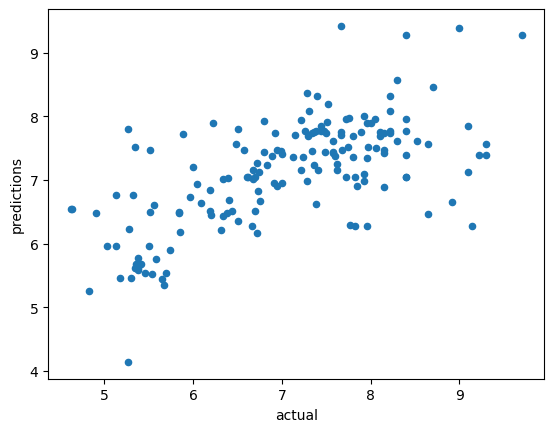

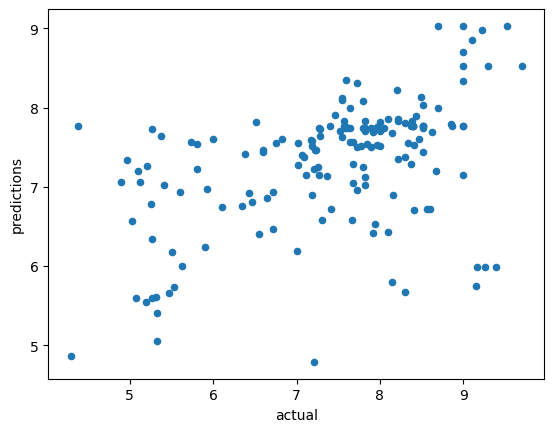

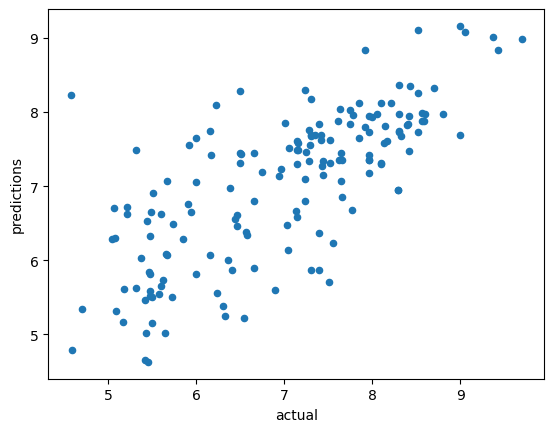

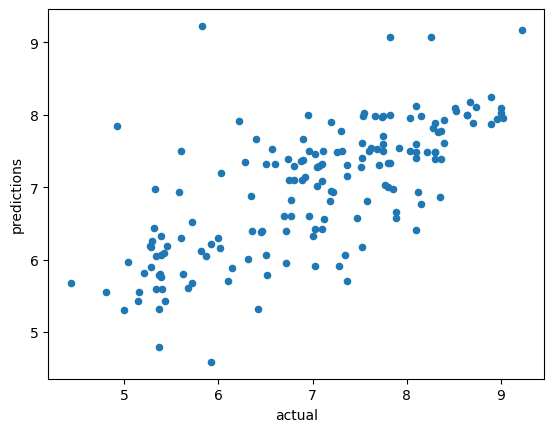

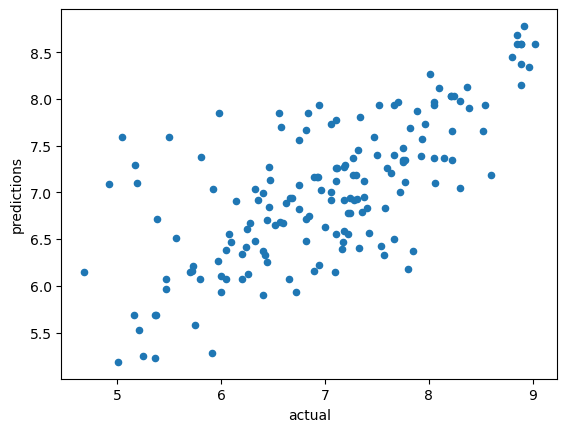

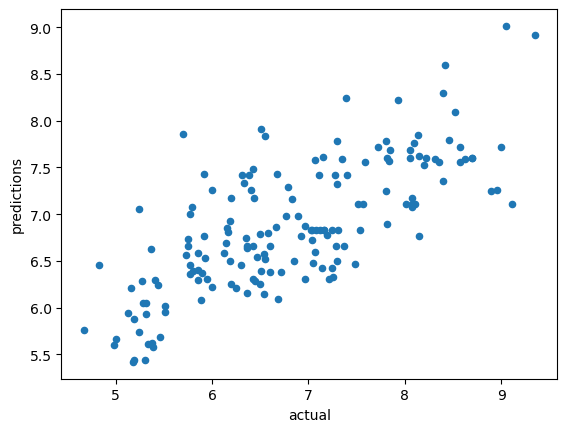

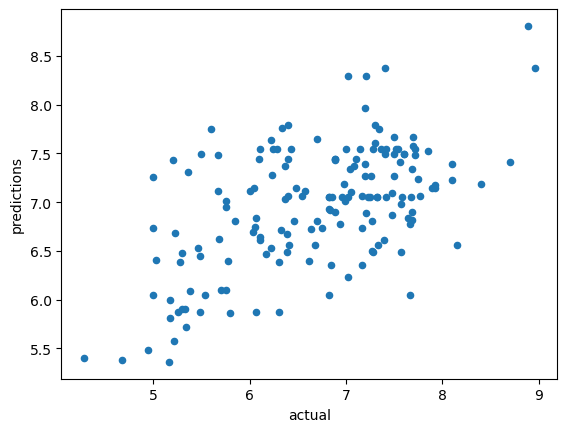

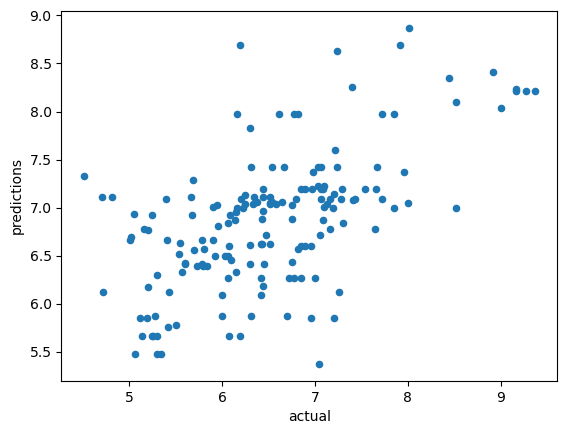

In [6]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df,false_disc, true_disc, true_ignore, false_ignore,rmse = perform_fcv(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [7]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(1, 3)
(0, 3)
(1, 3)
(2, 3)
(0, 3)
(1, 3)
(0, 3)
(0, 3)
(0, 3)


In [8]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(1, 3)
(1, 3)
(2, 3)
(5, 3)
(2, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [9]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(3, 3)
(8, 3)
(8, 3)
(7, 3)
(7, 3)
(6, 3)
(9, 3)
(10, 3)
(12, 3)


In [10]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(159, 3)
(155, 3)
(153, 3)
(150, 3)
(155, 3)
(157, 3)
(155, 3)
(153, 3)
(151, 3)


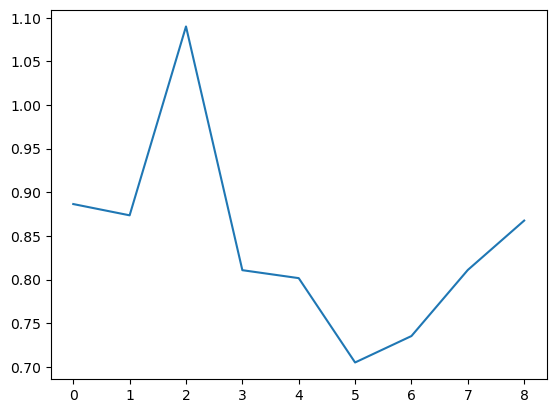

[0.886563395430621, 0.8736488879737582, 1.0899446904476904, 0.8108297970016763, 0.8017129046147774, 0.7051190042544575, 0.7354032867578549, 0.8110710961292834, 0.8676419364784829]


In [11]:
plt.plot(rmse)
plt.show()
print(rmse)

In [12]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

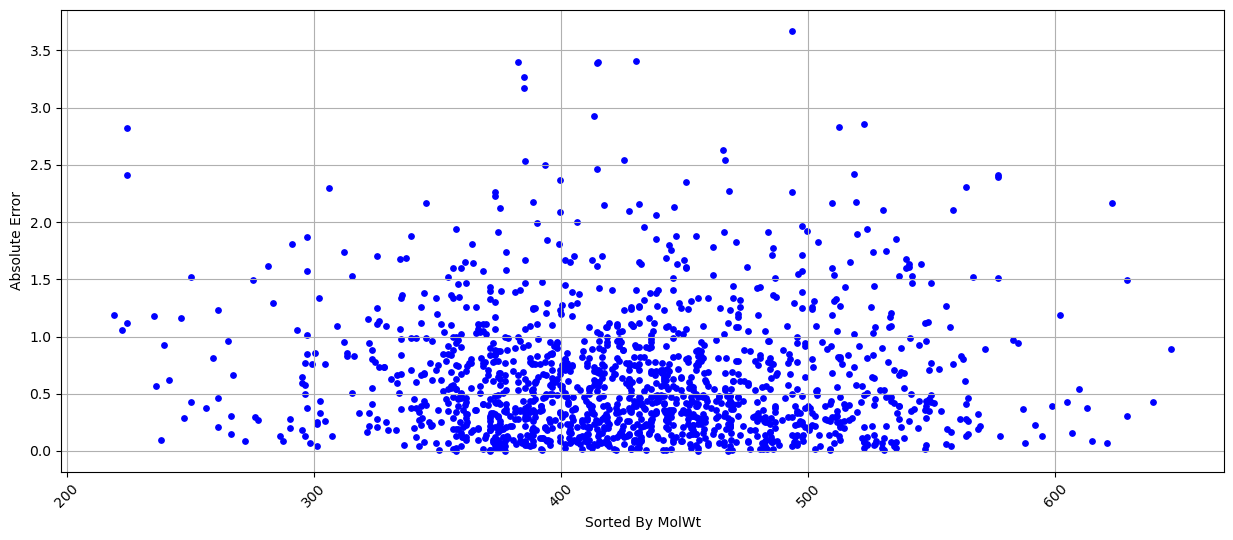

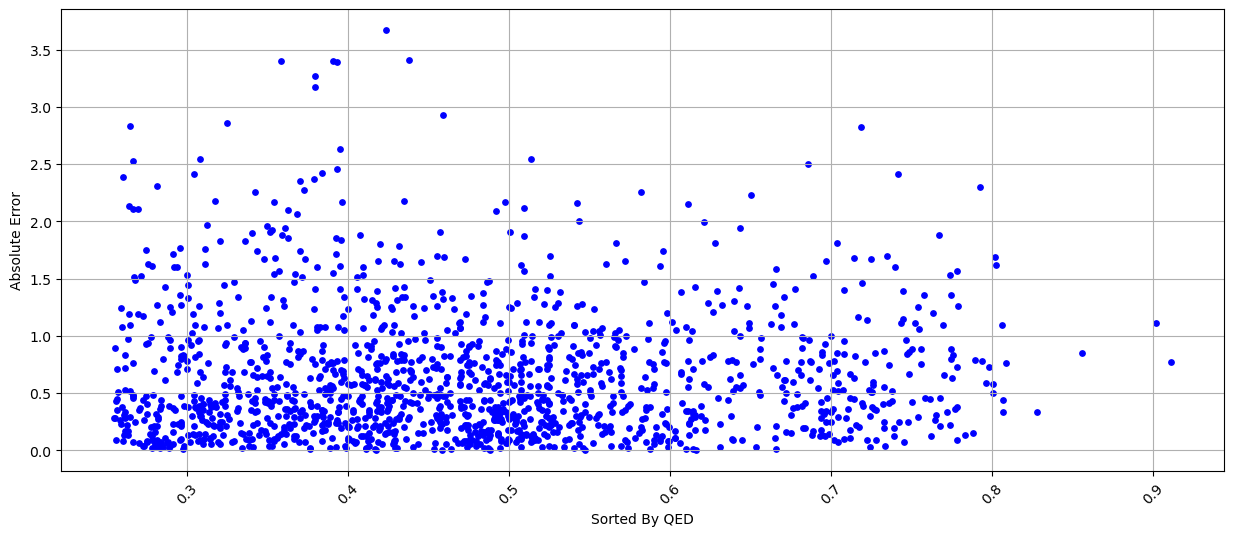

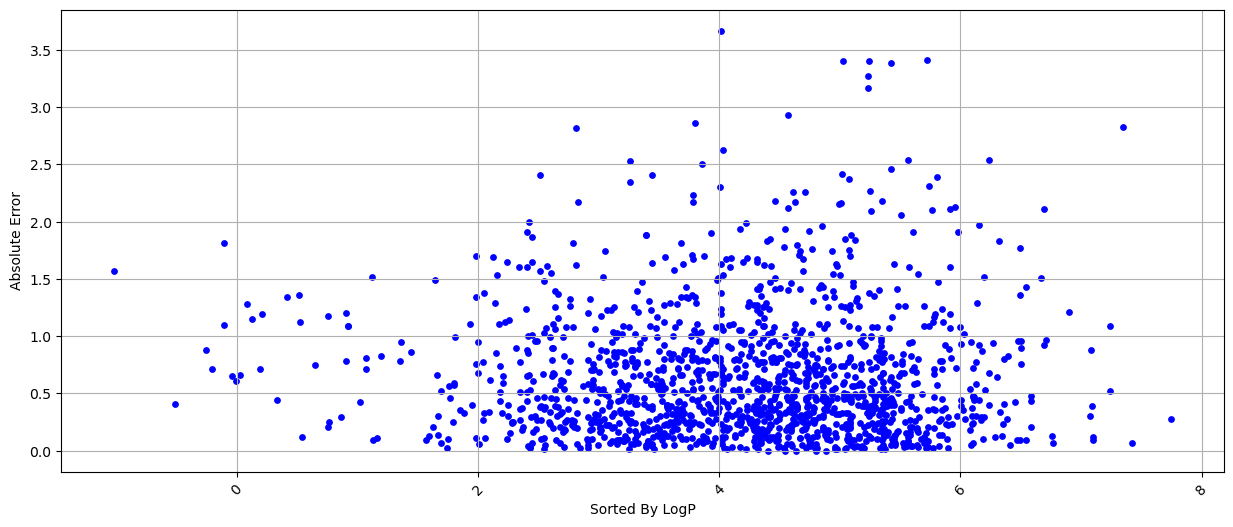

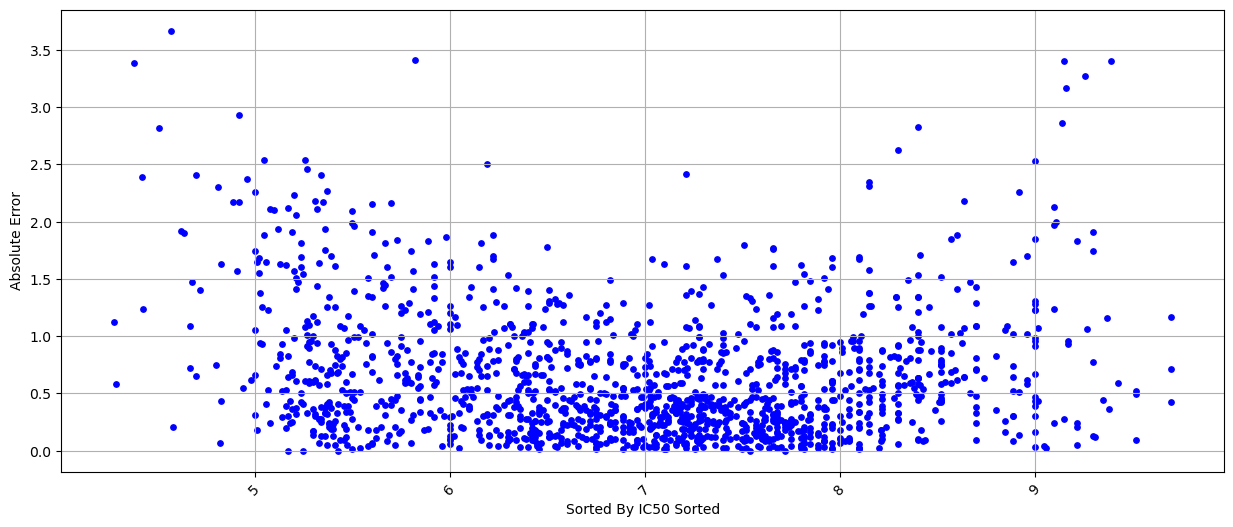

In [13]:
plot_graphs(df, results_df)

In [14]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
243,COc1cc(-c2cc(NC(=O)Nc3ccc(OCCCN4CCOCC4)cc3C)cc...,7.09,592.693,5.63112,0.107044,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1435,COc1cc(-c2cc(NC(=O)Nc3ccc(OCCCN(C)C)cc3C)cc(OC...,7.84,550.656,5.86052,0.112004,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
214,COc1cc2[nH]cnc(=Nc3ccc(Br)cc3)c2cc1OCCCCCCC(O)=NO,7.13,489.370,5.24140,0.118560,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1106,COc1cc2[nH]cnc(=Nc3ccc(Cl)cc3)c2cc1OCCCCCCC(O)=NO,6.67,444.919,5.13230,0.131771,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
792,COc1cc2[nH]cnc(=Nc3ccccc3Cl)c2cc1OCCCCCCC(O)=NO,6.44,444.919,5.13230,0.131771,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
1024,COc1cc2[nH]cnc(=Nc3ccccc3F)c2cc1OC,5.57,299.305,2.95160,0.808596,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
681,CCOc1[nH]c(=Nc2ccc(S(=N)(=O)CC)cc2)ncc1Br,7.05,385.287,3.22887,0.827970,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
333,Cn1cc(N=c2[nH]cc(C(F)(F)F)c(=NC3CC4CCC3C4)[nH]...,6.08,352.364,2.41680,0.855823,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
58,CCN(CC)C(=O)c1cccc(N2CCc3[nH]c(=N)ncc3C2)c1,5.90,325.416,1.93387,0.901718,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        
        X_test = X[(len(X)-fold_size):(len(X))]
        y_test = y[(len(X)-fold_size):(len(X))]
        smiles_test = smiles[(len(X)-fold_size):(len(X))] 
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = xgb.XGBRegressor(n_estimators=min(25, round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("sorted_fcv_results_xgboost_training batches_druglike.csv", index=False)
    test_df.to_csv("sorted_fcv_results_xgboost_testing batches_druglike.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })


    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=-0.20943402569014924, pvalue=0.0071138905588808525)
PearsonRResult(statistic=-0.4043033140664794, pvalue=7.916616733579604e-08)
PearsonRResult(statistic=-0.1625368286202202, pvalue=0.03757930295830755)
PearsonRResult(statistic=0.1624670428770572, pvalue=0.037662478157898874)
PearsonRResult(statistic=0.30085264409286905, pvalue=9.062722652098231e-05)
PearsonRResult(statistic=0.37566515505395487, pvalue=7.164935671526179e-07)
PearsonRResult(statistic=0.4620184204690524, pvalue=4.741602793903726e-10)
PearsonRResult(statistic=0.5914916317344047, pvalue=7.467992957691049e-17)
PearsonRResult(statistic=0.5962746337392872, pvalue=3.6397862741375956e-17)


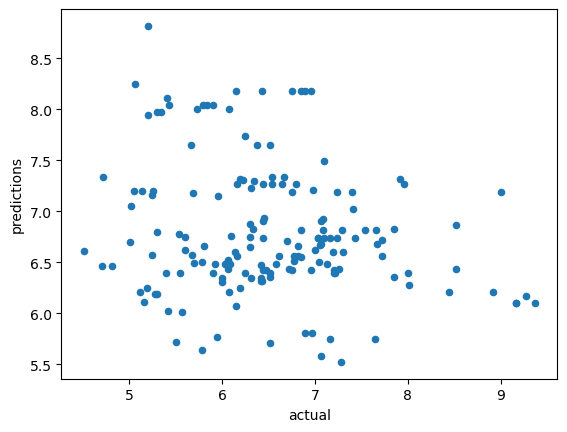

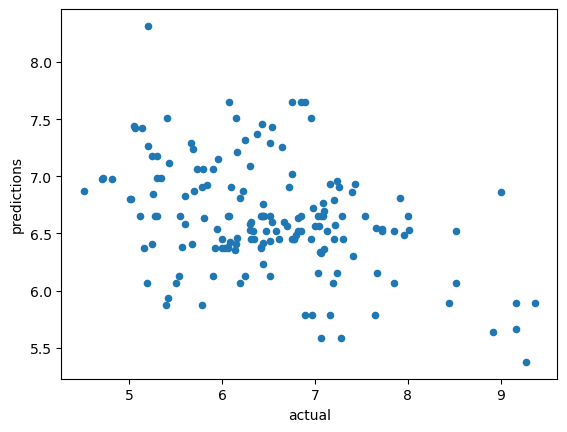

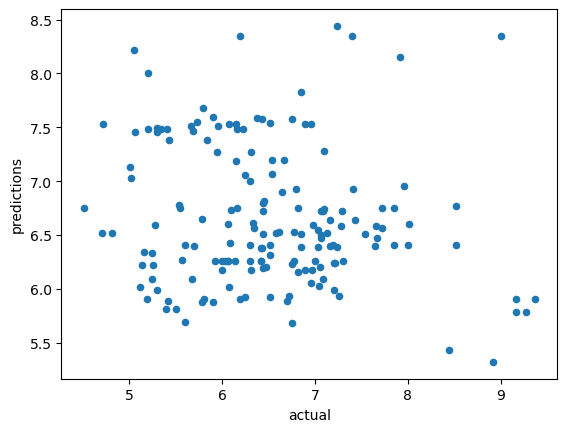

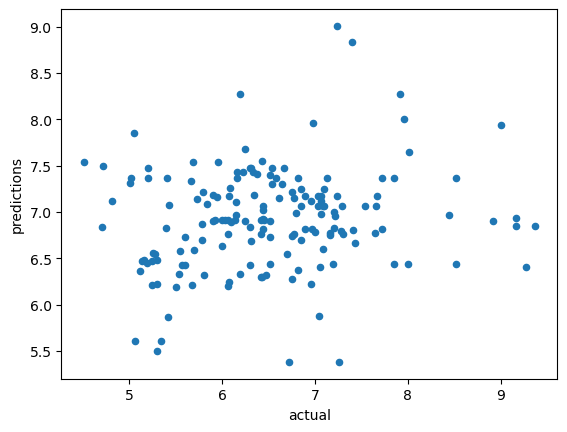

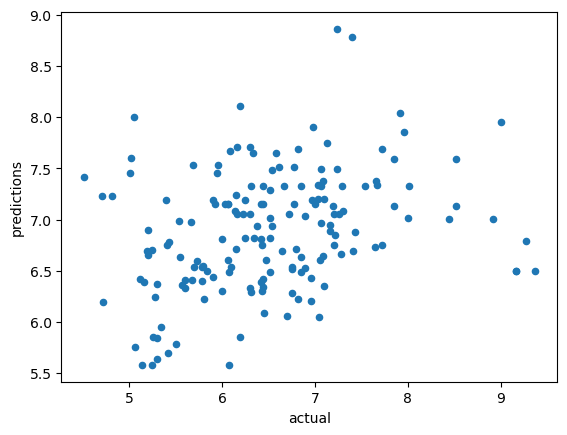

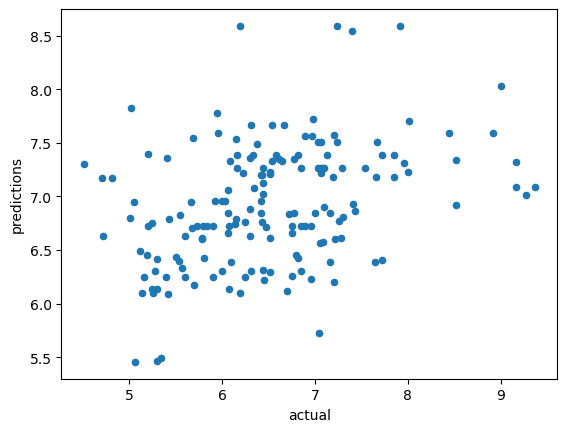

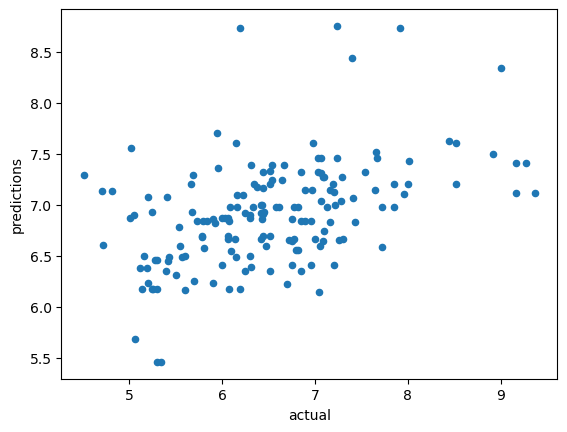

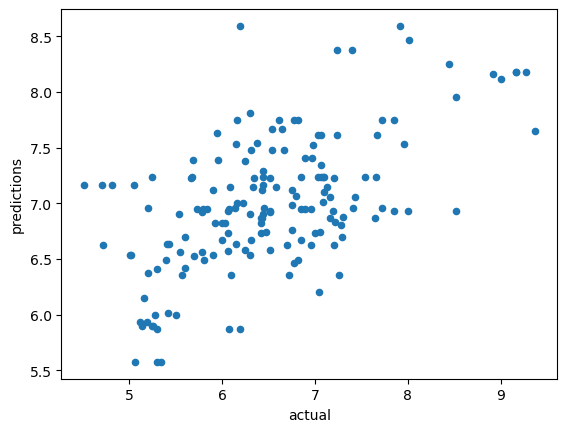

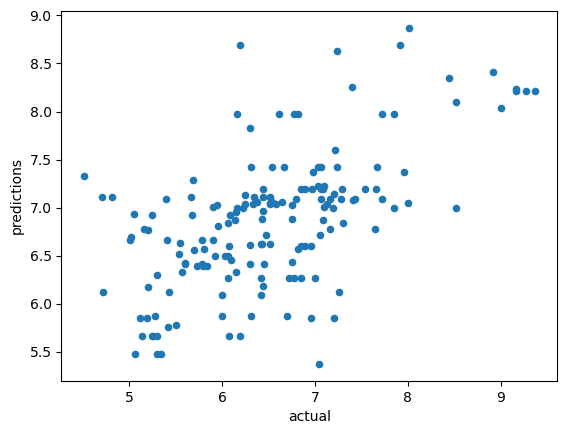

In [16]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_fcv_on_most_druglike(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [17]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [18]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [19]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(150, 3)
(150, 3)
(150, 3)
(150, 3)
(150, 3)
(150, 3)
(150, 3)
(150, 3)
(150, 3)


In [20]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(12, 3)
(12, 3)
(12, 3)
(12, 3)
(12, 3)
(12, 3)
(12, 3)
(12, 3)
(12, 3)


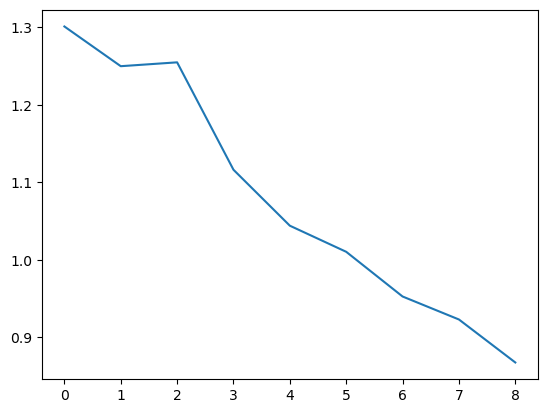

[1.3011579098908803, 1.2498949492375824, 1.2548719178905312, 1.1162300313751745, 1.0440223647717544, 1.0103312384992615, 0.952645524130537, 0.9229712130734834, 0.8674854209387372]


In [21]:
plt.plot(rmse)
plt.show()
print(rmse)